In [1]:
import datetime

# Get the current date
current_date = datetime.date.today()

# Print "Last run day:" followed by the current date
print(f"Last run day: {current_date}")


Last run day: 2024-08-06


# Overview 

This notebook describes how to construct GRN models in CellOracle. 
Please read our paper first to know about the CellOracle's GRN modeling algorithm.

Last update: 4/13/2022, Kenji Kamimoto

### Notebook file
Notebook file is available on CellOracle's GitHub page.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.ipynb


### Data
CellOracle uses two types of input data during the GRN model construction.

- **Input data 1: scRNA-seq data**. Please look at the previous section to learn about the scRNA-seq data preprocessing. https://morris-lab.github.io/CellOracle.documentation/tutorials/scrnaprocess.html


- **Input data 2: Base-GRN**. The base GRN represents the TF-target gene connections. The data structure is a binary 2D matrix or linklist. Please look at our paper to know the concept of base GRN.

 - CellOracle typically uses a base GRN constructed from scATAC-seq data. If you would like to create a custom base GRN using your scATAC-seq data, please refer to the following notebook. https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html
 - If you do not have any sample-specific scATAC-seq data that correspond to the same/similar cell type of the scRNA-seq data, please use pre-built base GRN.  
 - We provide multiple options for pre-built base GRN. For analyses in mice, we recommend using a base GRN built from the mouse sciATAC-seq Atlas dataset. It includes various tissues and various cell types. Another option is using base GRN constructed from promoter database. We provide promoter base GRNs for ten species.

### What you can do
After constructing the CellOracle GRN models, you can do two analyses.

1. **in silico TF perturbation analysis**. CellOracle uses the GRN models to simulate cell identity shifts in response to TF perturbation. For this analysis, you must first construct your GRN models in this notebook.

2. **Network analysis**. You can analyze the GRN models using graph theory. We provide several functions. 
 - CellOracle construct cluster-wise GRN models. You can compare the GRN model structure between clusters, which allows you to investigate the cell type-specific GRN configurations and explore structual changes as GRNs are rewired along the cell differentiation trajectory.
 - You can also export the network models and analyze the GRN models using external packages or softwares. 
 
### Custom data classes / objects

In this notebook, CellOracle uses two custom classes, `Oracle` and `Links`.

- `Oracle` is the main class in the CellOracle package. It is responsible for almost all the GRN model construction and TF perturbation simulation. `Oracle` does the following calculations sequentially.
 1. Import scRNA-sequence data. Please refer to the data preparation notebooks to learn about data preparation procedures.
 2. Import base GRN data.
 3. scRNA-seq data processing. 
 4. GRN model construction.
 5. in silico petrurbation. We will describe how to do this in the following notebook.

- `Links` is a class to store GRN data. It also conteins many functions for network analysis and visualization.


# 0. Import libraries

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [3]:
import celloracle as co
co.__version__

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'0.12.0'

In [4]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [5]:
path = os.getcwd()
path
# run this notebook from the root of the repository
os.chdir(path)


# files in this directory
# print("File e directory in '", os.getcwd(), "':", os.listdir(os.getcwd()))


## 0.2. Make a folder to save graph

In [6]:
save_folder = "figures_GRN_inference"
os.makedirs(save_folder, exist_ok=True)


# 1. Load data
## 1.1. Load processed gene expression data (anndata)

Please refer to the previous notebook to learn about scRNA-seq data processing.
https://morris-lab.github.io/CellOracle.documentation/tutorials/scrnaprocess.html

The scRNA-seq data must be in the anndata format.

> **This CellOracle tutorial notebook assumes the user has basic knowledge and experience with scRNA-seq analysis using Scanpy and Anndata.** This notebook is not intended to be an introduction to Scanpy or Anndata. 
> If you are not familiar with them, please learn them using the documentation and tutorials for Scanpy (https://scanpy.readthedocs.io/en/stable/) and annata (https://anndata.readthedocs.io/en/stable/).



In [7]:
# scRNA-seq dataset
adata = sc.read_h5ad("data/OurData_processedforCellOracle_21_11_23_umap.h5ad")
adata.shape



(9696, 2100)

In [8]:
general_path = os.path.dirname(path)
general_path

'/data'

## Load signatures that we use as higly variable genese


In [9]:
# Load genes from signatures (Carbognin et al.): relevant genes
signatures_genes = pd.read_csv(general_path+'/sc_ge_data/6 signatures.txt', sep='\t')
genes_list = set(signatures_genes['Symbol'].tolist())  # Use set to remove duplicates

# Load genes from CSV file
csv_path = general_path+'/sc_ge_data/genes_order.csv' # 24 genes used for IGNITE and SCODE
genes_df = pd.read_csv(csv_path, header=None)
genes_list_sel = set(genes_df[0].tolist())  # Use set to remove duplicates

# Merge the two sets of genes without duplicates
genes_list.update(genes_list_sel)  # Merges gene set with selected ones

# Select genes present in the scRNA-seq dataset: common genes with adata.var_names
common_genes = genes_list.intersection(set(adata.var_names))

# Print useful information
print(f"Total genes from signatures: {len(signatures_genes)}")
print(f"Total genes from CSV: {len(genes_df)}")
print(f"Total unique genes combined: {len(genes_list)}")
print(f"Total relevant genes in scRNA-seq data: {len(common_genes)}")

# Filter adata for common genes
adata = adata[:, list(common_genes)].copy()

# Print the shape of the adata subset
print(f"adata subset shape: {adata.shape}")


Total genes from signatures: 2640
Total genes from CSV: 24
Total unique genes combined: 2322
Total relevant genes in scRNA-seq data: 2078
adata subset shape: (9696, 2078)


## 1.2. (Optional step) Downsampling

If your scRNA-seq data includes more than 20-30K cells, we recommend downsampling your data. If you do not, please note the perturbation simulations may require large amounts of memory in the next notebook. 

Also, please pay attention to the number of genes. If you are following the instruction from the previous tutorial notebook, the scRNA-seq data should include only top 2~3K variable genes. If you have more than 3K genes, it may cause issues downstream.

In [10]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

# Our data don't need downsampling

Cell number is :9696
Gene number is :2078


In [11]:
# Random downsampling into 30K cells if the anndata object include more than 30 K cells.
n_cells_downsample = 30000 
if adata.shape[0] > n_cells_downsample:
    # Let's dowmsample into 30K cells
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

In [12]:
print(f"Cell number is :{adata.shape[0]}")

Cell number is :9696


## 1.2. Load base-GRN data. 
To infer cluster-specific GRNs, CellOracle requires a base GRN. 
- There are several ways to make a base GRN. We can typically generate base GRN from scATAC-seq data or bulk ATAC-seq data. Please refer to the first step of the tutorial to learn more about this process. https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html


- If you do not have your scATAC-seq data, you can use one of the built-in base GRNs options below. 

- Base GRNs made from mouse sci-ATAC-seq atlas : The built-in base GRN was made from various tissue/cell-types found in the atlas (http://atlas.gs.washington.edu/mouse-atac/). We recommend using this for mouse scRNA-seq data. Please load this data as follows.

 `base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()`


- Promoter base GRN: We also provide base GRN made from promoter DNA-sequences for ten species. You can load this data as follows.

 - e.g. for Human: `base_GRN = co.data.load_human_promoter_base_GRN()`



In [13]:
# Load TF info which was made from mouse cell atlas dataset. 
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

# Check data
print("base_GRN info:")
print(base_GRN.shape)

base_GRN.head(2)

Data not found in the local folder. Loading data from github. Data will be saved at /root/celloracle_data/TFinfo_data


  0%|          | 0.00/9.01M [00:00<?, ?B/s]

base_GRN info:
(91976, 1095)


,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
numeric_data = base_GRN.iloc[:, 2:]

# Numeric values
numeric_values = np.array(numeric_data)
unique_numeric_values = np.unique(numeric_values)

print("unique numeric values", unique_numeric_values)


unique numeric values [0. 1.]


In [15]:
# full GRN: set to 1 the elements equal to 0
full_GRN = base_GRN.copy()
full_GRN = full_GRN.replace(0, 1)
full_GRN.head(3)

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,chr10_101006922_101007748,SNORA17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,chr10_101144061_101145000,Mgat4c,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
# Copy the relevant genes to a new list
relevant_genes = genes_list_sel.copy()

# Filter the DataFrame for relevant genes
filtered_df = full_GRN[full_GRN['gene_short_name'].isin(relevant_genes)]

# Find relevant genes not present in filtered_df
genes_not_found = set(relevant_genes) - set(filtered_df['gene_short_name'])

# Count the number of unique relevant genes found in the DataFrame
num_relevant_genes = len(filtered_df['gene_short_name'].unique())

# Print the number of relevant genes found
print(f"Number of relevant genes found: {num_relevant_genes}")

# Print the relevant genes not found in filtered_df
print(f"Relevant genes not found in filtered_df: {genes_not_found}")

full_GRN[full_GRN["gene_short_name"]=="Nr0b1"]


Number of relevant genes found: 21
Relevant genes not found in filtered_df: {'Nanog', 'Tfcp2l1', 'Nr0b1'}


,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4


In [17]:
# Add manually the missed genes
new_rows_data = {
    'peak_id': ['ch', 'ch', 'ch'],
    'gene_short_name': ['Nr0b1', 'Nanog', 'Tfcp2l1'],
}

print(full_GRN.shape)

# set the links
for col in full_GRN.columns[2:]:
    new_rows_data[col] = [1, 1, 1]

new_rows_df = pd.DataFrame(new_rows_data)

# add row to fully connected network datafrae keeping the structure
full_GRN = pd.concat([full_GRN, new_rows_df], ignore_index=True)


(91976, 1095)


In [22]:
# Check
full_GRN[full_GRN["gene_short_name"]=="Nr0b1"]

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4,Utf1,Dnmt3b,Dnmt3a
91976,ch,Nr0b1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,1


In [19]:
# Find the genes from 'relevant_genes' that are not column names in full_GRN
genes_not_in_full_GRN = relevant_genes - set(full_GRN.columns)

# Print the genes that are not present as column names in full_GRN
print(f"Genes not present as column names in full_GRN: {genes_not_in_full_GRN}")

# Create new columns for genes not present in full_GRN and fill them with 1
for gene in genes_not_in_full_GRN:
    full_GRN[gene] = 1

# Print the DataFrame with the new columns added
print(full_GRN.shape)

Genes not present as column names in full_GRN: {'Utf1', 'Dnmt3b', 'Dnmt3a'}
(91979, 1098)


In [20]:
base_GRN = full_GRN.copy()

In [21]:
numeric_data = base_GRN.iloc[:, 2:]

# Numeric values
numeric_values = np.array(numeric_data)
unique_numeric_values = np.unique(numeric_values)

print("unique numeric values", unique_numeric_values)


unique numeric values [1.]


### 1.2.1 Plot the adjacency matrix that we want (trivial fully connected network)

In [27]:
# rows and cols in base_GRN
row_names_map = {name.lower(): name for name in base_GRN["gene_short_name"]}
column_names_map = {name.lower(): name for name in base_GRN.columns}

# genes_list_sel in set lowercase
genes_set = {gene.lower() for gene in genes_list_sel}

# common genes
common_with_rows_lower = genes_set.intersection(set(row_names_map.keys()))
common_with_rows = {row_names_map[gene] for gene in common_with_rows_lower}


common_with_columns_lower = genes_set.intersection(set(column_names_map.keys()))
common_with_columns = {column_names_map[gene] for gene in common_with_columns_lower}



print(f"Comon with rows: {common_with_rows}, {len(common_with_rows)}")
print(f"Commn with cols: {common_with_columns}, {len(common_with_columns)}")


# Not common elements
not_common_with_rows = genes_set.difference(set(row_names_map.keys()))
not_common_with_columns = genes_set.difference(set(column_names_map.keys()))

# Stampa gli elementi di genes_list_sel non comuni
print(f"Not comon - rows:: {not_common_with_rows}, {len(not_common_with_rows)}")
print(f"Not common - cols: {not_common_with_columns}, {len(not_common_with_columns)}")



Comon with rows: {'Utf1', 'Esrrb', 'Tbx3', 'Lef1', 'Nr0b1', 'Rbpj', 'Sall4', 'Klf4', 'Sox2', 'Nanog', 'Dnmt3b', 'Etv5', 'Tfcp2l1', 'Klf2', 'Otx2', 'Etv4', 'Pou3f1', 'Tcf15', 'Gbx2', 'Pou5f1', 'Zic3', 'Tcf7l1', 'Stat3', 'Dnmt3a'}, 24
Commn with cols: {'Utf1', 'Esrrb', 'Tbx3', 'Lef1', 'Nr0b1', 'Rbpj', 'Sall4', 'Klf4', 'Sox2', 'Nanog', 'Dnmt3b', 'Etv5', 'Tfcp2l1', 'Klf2', 'Otx2', 'Etv4', 'Pou3f1', 'Tcf15', 'Gbx2', 'Pou5f1', 'Zic3', 'Tcf7l1', 'Stat3', 'Dnmt3a'}, 24
Not comon - rows:: set(), 0
Not common - cols: set(), 0


In [28]:
#  removing unused info
# Indexing base_GRN by gene names for easier row access
filtered_GRN = base_GRN.set_index('gene_short_name')
filtered_GRN.index.name = None # remove the name of the index

# remove the column "peak_id"
filtered_GRN = filtered_GRN.drop(columns=['peak_id'])
filtered_GRN.head(3)

# Select rows and cols in which we are interested
selected_GRN = filtered_GRN.loc[common_with_rows, common_with_columns]
selected_GRN = selected_GRN.groupby(selected_GRN.index).max()
selected_GRN = selected_GRN.rename(columns={'GBX2': 'Gbx2', 'NR0B1': 'Nr0b1'})

print ("GRN shape after grouping:", selected_GRN.shape)
selected_GRN.head(2)

GRN shape after grouping: (24, 24)


,Utf1,Esrrb,Tbx3,Lef1,Nr0b1,Rbpj,Sall4,Klf4,Sox2,Nanog,...,Otx2,Etv4,Pou3f1,Tcf15,Gbx2,Pou5f1,Zic3,Tcf7l1,Stat3,Dnmt3a
Dnmt3a,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
Dnmt3b,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [30]:
all_genes = genes_df.iloc[:,0].tolist()  
full_GRN = pd.DataFrame(0, index=all_genes, columns=all_genes)

# inserting the known interactions
for gene_row in selected_GRN.index:
    for gene_col in selected_GRN.columns:
        if gene_row in full_GRN.index and gene_col in full_GRN.columns:
            full_GRN.at[gene_row, gene_col] = selected_GRN.at[gene_row, gene_col]

# Commented plot because it's fully connected
# plt.figure(figsize=(12, 10))
# sns.heatmap(full_GRN.T, annot=False, cmap='viridis')
# plt.title("Base GRN")
# plt.show()

In [33]:
def check_signs(adjacency_matrix, known_interactions):
    """
    Checks the number of present interactions in the interaction matrix based on a list of known interactions.

    Parameters:
    adjacency_matrix (pd.DataFrame): A pandas DataFrame representing the adjacency matrix.
    known_interactions (list): A list of known interactions in the format "Gene1 Gene2 Sign".

    Returns:
    float: The fraction of existing interactions (indipendet from sign).
    """
    # Parse the known_interactions
    parsed_list = [item.split() for item in known_interactions]

    # Initialize a counter for correct signs
    correct_signs = 0

    for gene_from, gene_to, sign in parsed_list:
        if gene_from in adjacency_matrix.index and gene_to in adjacency_matrix.columns:
            # Compare sign from the list with the sign in the matrix
            if np.sign(adjacency_matrix.loc[gene_to,gene_from]) == abs(int(sign)): # abs to not consider the sign
                correct_signs += 1
                # print("Correct interaction", gene_from, gene_to)

    # Calculate and return the fraction of correct signs
    return correct_signs / len(known_interactions)



In [34]:
known_interactions = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


result_2 = check_signs(full_GRN, known_interactions)
print(f"Fraction of correct signs in base GRN with Carbognin data: {result_2:.2f}") 

Fraction of correct signs in base GRN with Carbognin data: 1.00


# 2. Make Oracle object

We will use an Oracle object during the data preprocessing and GRN inference steps. Using its internal functions, the Oracle object computes and stores all of the necessary information for these calculations. To begin, we will instantiate a new Oracle object and input our gene expression data (anndata) and TF info (base GRN).

In [38]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

For the CellOracle analysis, your anndata should include (1) gene expression counts, (2) clustering information, and (3) trajectory (dimensional reduction embedding) data. Please refer to a previous notebook for more information on anndata preprocessing.


When you load the scRNA-seq data, please enter **the name of the clustering data** and **the name of the dimensionality reduction.**
 - The clustering data should be to be stored in the `obs` the attribute of anndata. 
  > You can check it using the following command.
  >
  > `adata.obs.columns`
  
 - Dimensional reduction data is stored in the `obsm` the attribute of anndata. 
  > You can check it with the following command.
  > 
  > `adata.obsm.keys()`
  


In [39]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['hashID', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'cluster', 'slingPseudotime_1', 'n_counts']
Dimensional reduction:  ['PCA', 'TSNE', 'UMAP', 'UMAP_temp', 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap']


In [40]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="cluster",
                                   embedding_name="X_draw_graph_fr")

## 2.2. Load base-GRN data into oracle object

In [41]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN) # without selecting the genes in the GRN
# oracle.import_TF_data(TF_info_matrix=cleaned_GRN_with_rep)



# 3. KNN imputation
CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

## 3.1. PCA

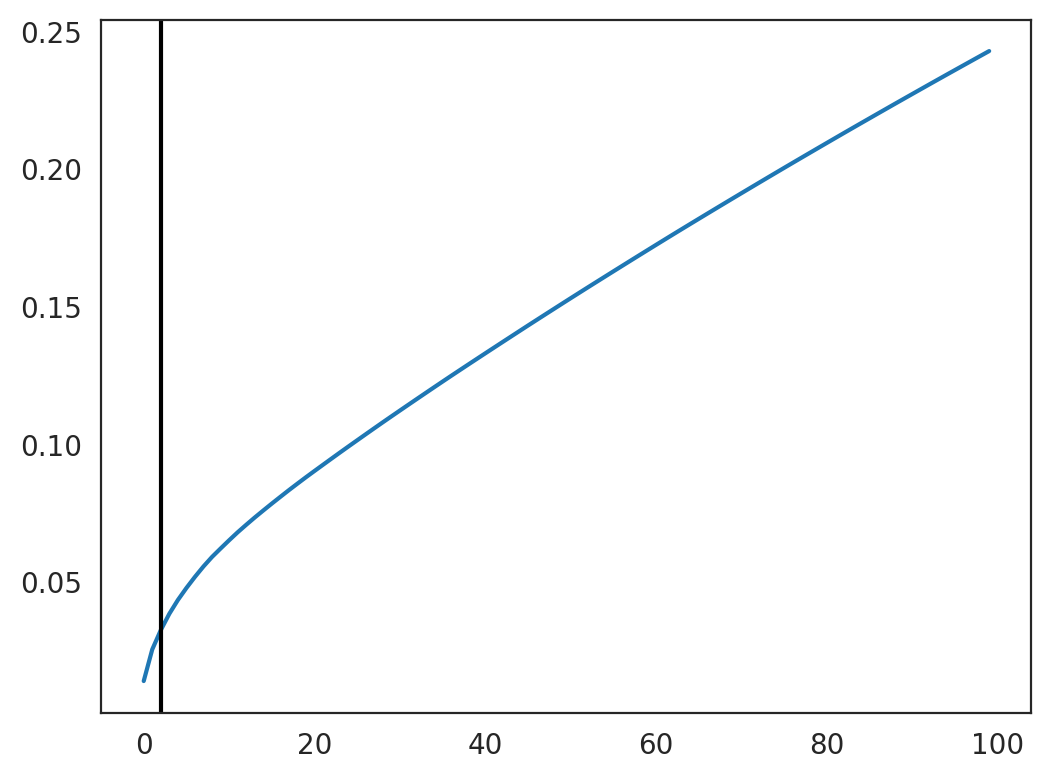

2


In [42]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.005))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)
# n_comps = 50

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [43]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :9696


In [44]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :242


In [45]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# 4. Save and Load.

You can save your `Oracle` object using `Oracle.to_hdf5(FILE_NAME.celloracle.oracle)`. 

Pleasae use `co.load_hdf5(FILE_NAME.celloracle.oracle)` to load the saved file.


In [46]:
# string with the date of today in format dd_mm_yy
from datetime import date
today = date.today()
d1 = today.strftime("%d_%m_%y")


In [47]:
path

'/data/scRNA_our_signatures'

In [37]:
# Save oracle object.
oracle.to_hdf5(path+"/Our_data_"+d1+"_signatures_FullyConnectedGRN.celloracle.oracle")

In [ ]:
# Load file.
oracle = co.load_hdf5(path+"/Our_data_"+d1+"_signatures_FullyConnectedGRN.celloracle.oracle")

# 5. GRN calculation
The next step constructs a cluster-specific GRN for all clusters.

- You can calculate GRNs with the `get_links` function, and it will return the results as a `Links` object.
The `Links` object stores the inferred GRNs and the corresponding metadata. Most network structure analysis is performed with the `Links` object.

- A GRN will be calculated for each cluster/sub-group. In the example below, we construct GRN for each unit of the "louvain_annot" clustering.



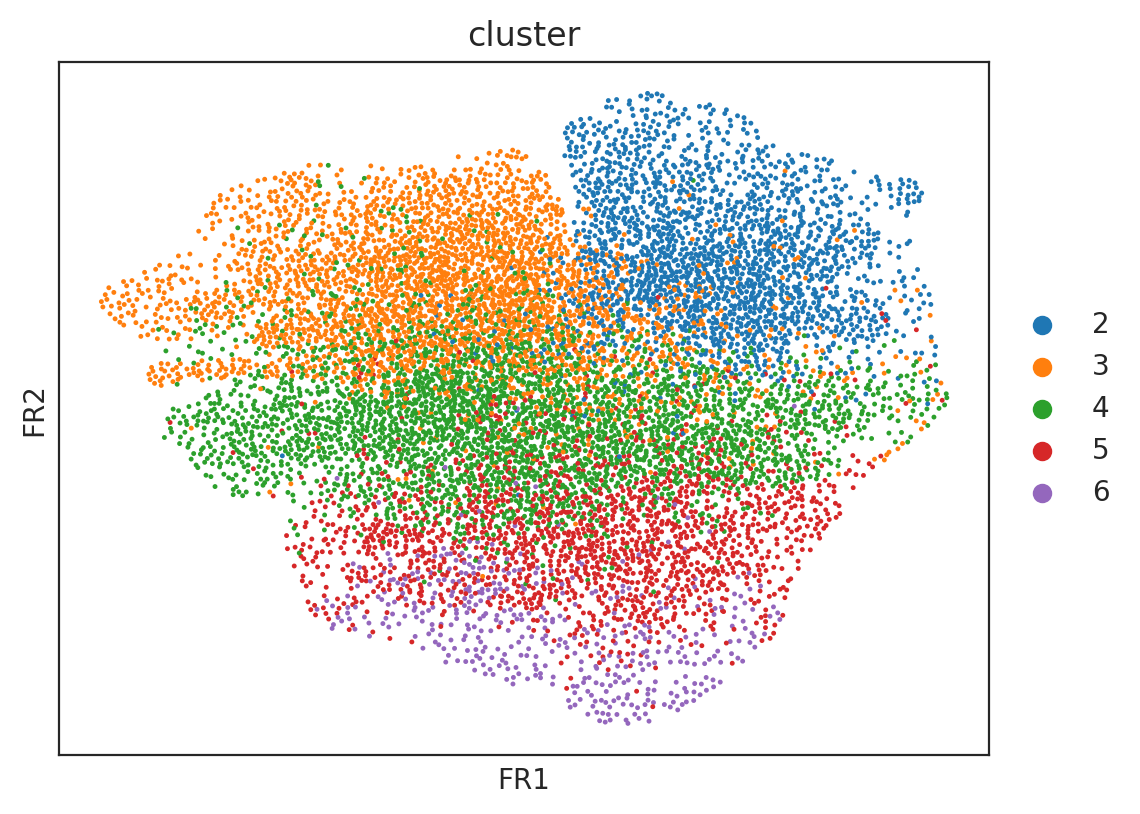

In [48]:
# Check clustering data
sc.pl.draw_graph(oracle.adata, color="cluster")

## 5.1. Get GRNs

In [49]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="cluster", alpha=10,
                         verbose_level=10)

  0%|          | 0/5 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/1825 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/1825 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/1825 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/1825 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/1825 [00:00<?, ?it/s]

CPU times: user 11min 54s, sys: 32.5 s, total: 12min 27s
Wall time: 24min 18s


# 6. Network preprocessing

## 6.1. Filter network edges 

Using the base GRN, CellOracle constructs the GRN models as a lits of directed edges between a TF and its target genes.
We need to remove the weak edges or insignificant edges before doing network structure analysis.

We filter the network edges as follows.

1. Remove uncertain network edges based on the p-value.
 
2. Remove weak network edge. In this tutorial, we keep the top 2000 edges ranked by edge strength.


The raw network data is stored in the `links_dict` attribute, while the filtered network data is stored in the `filtered_links` attribute. 


In [50]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

## 6.2. Degree distribution 
In the first step, we examine the network degree distribution.

>Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure (https://en.wikipedia.org/wiki/Degree_distribution).

Please keep in mind that the degree distribution may change depending on the filtering threshold.

In [51]:
plt.rcParams["figure.figsize"] = [9, 4.5]

2


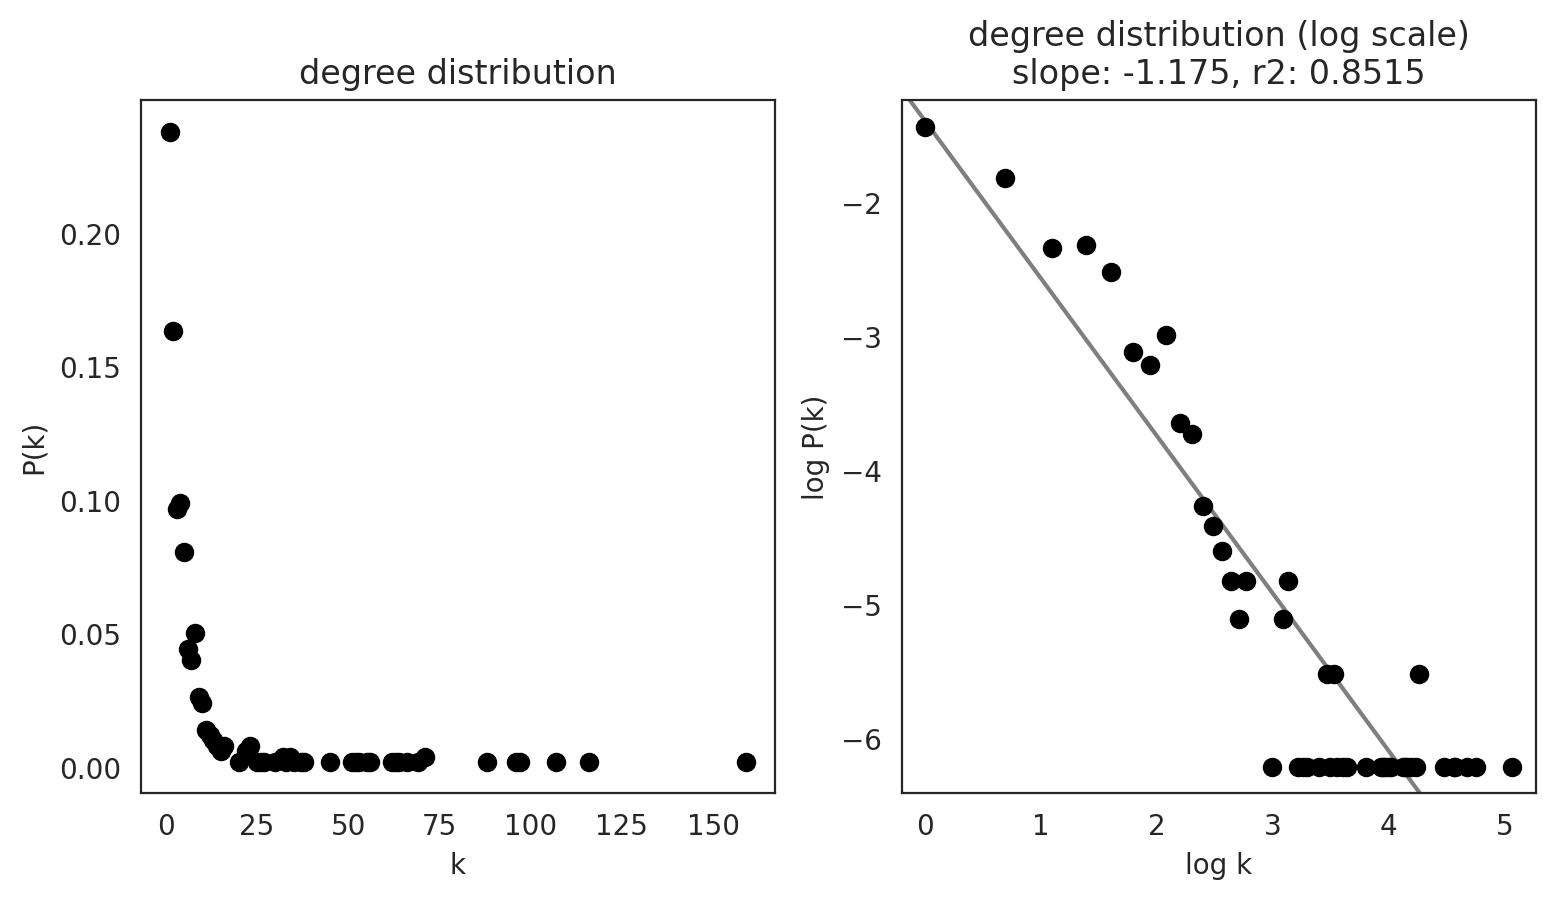

3


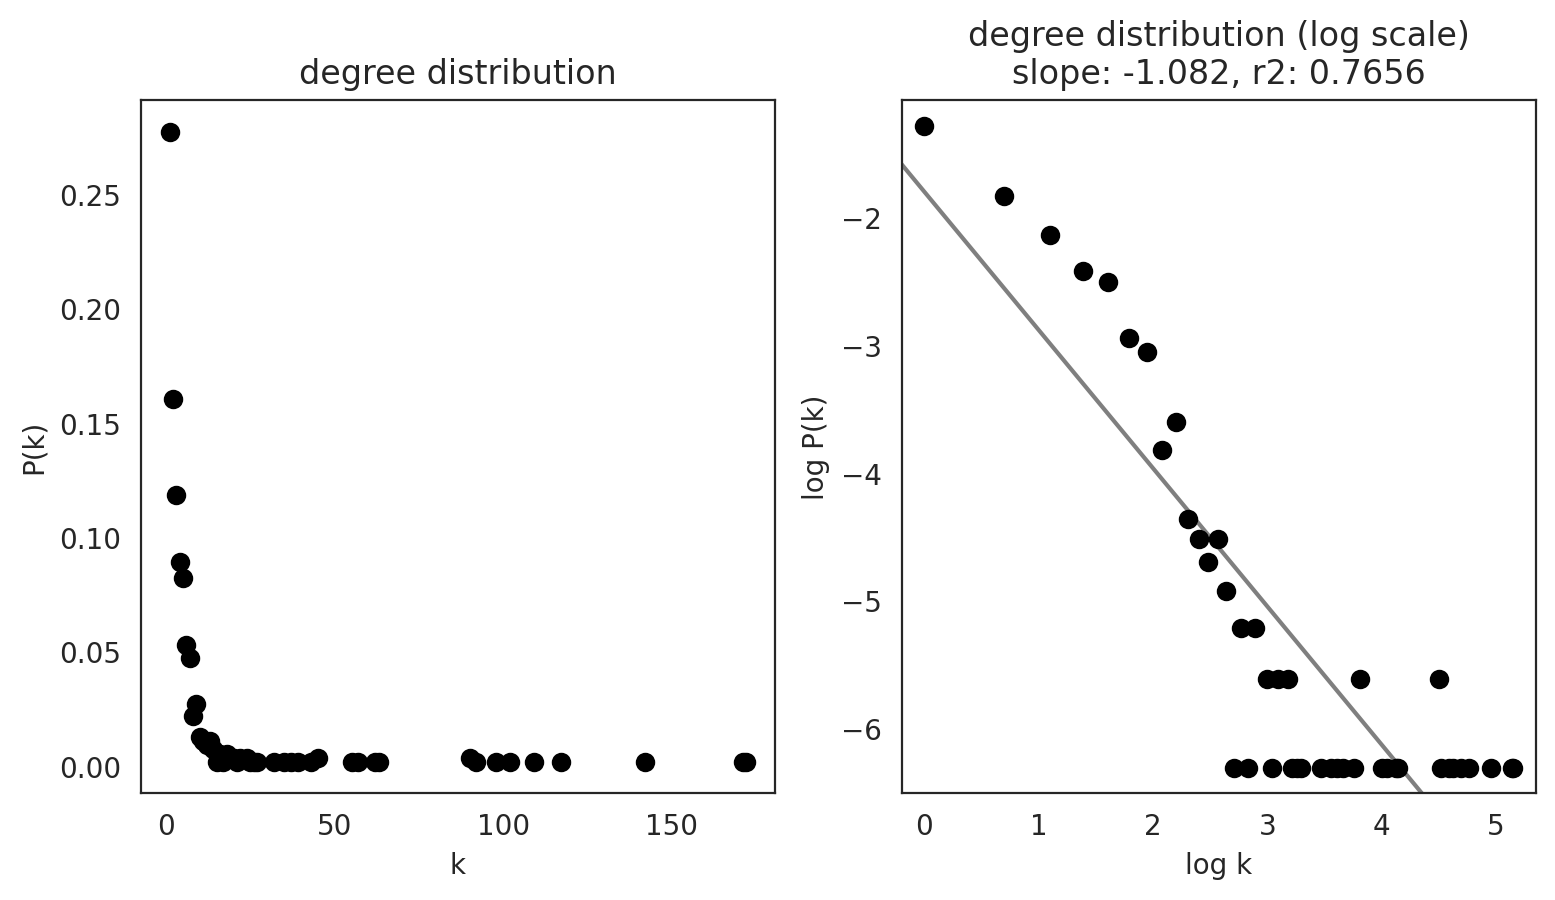

4


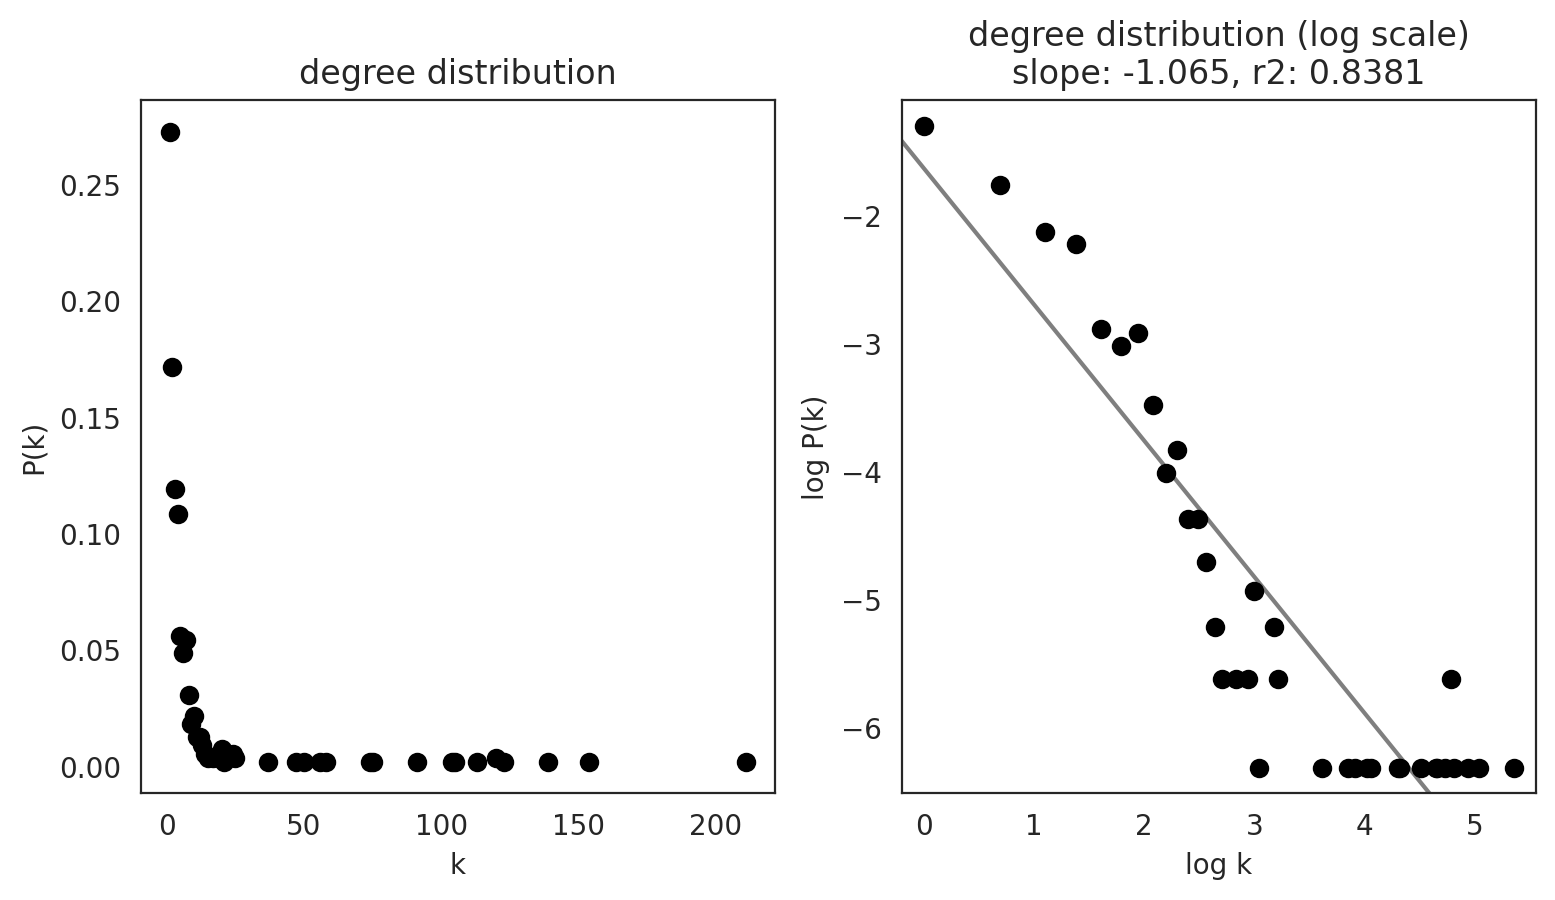

5


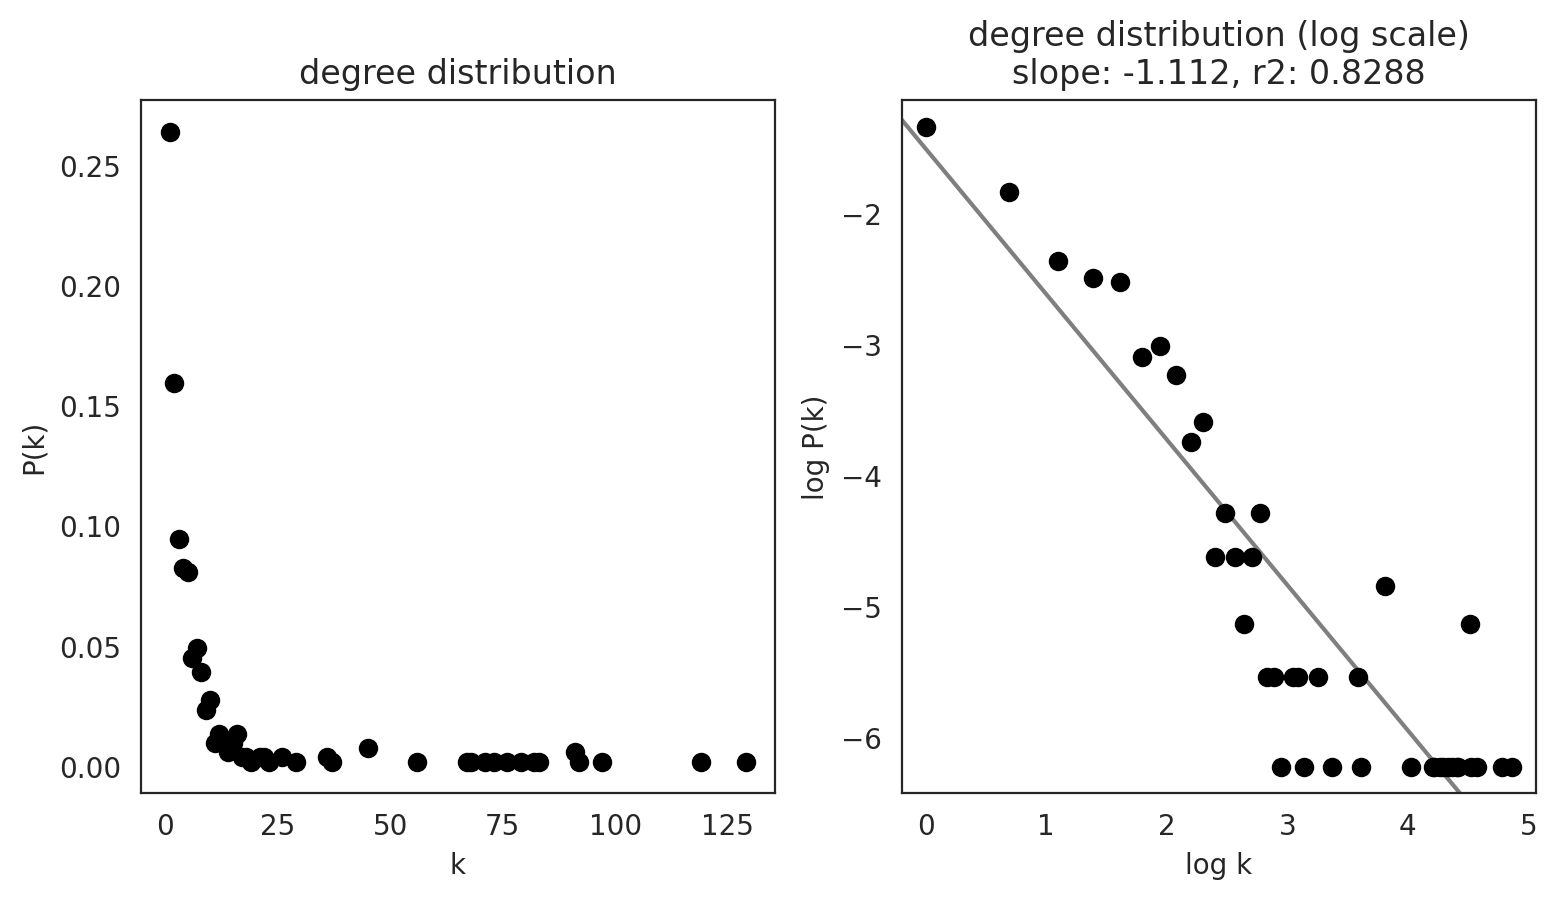

6


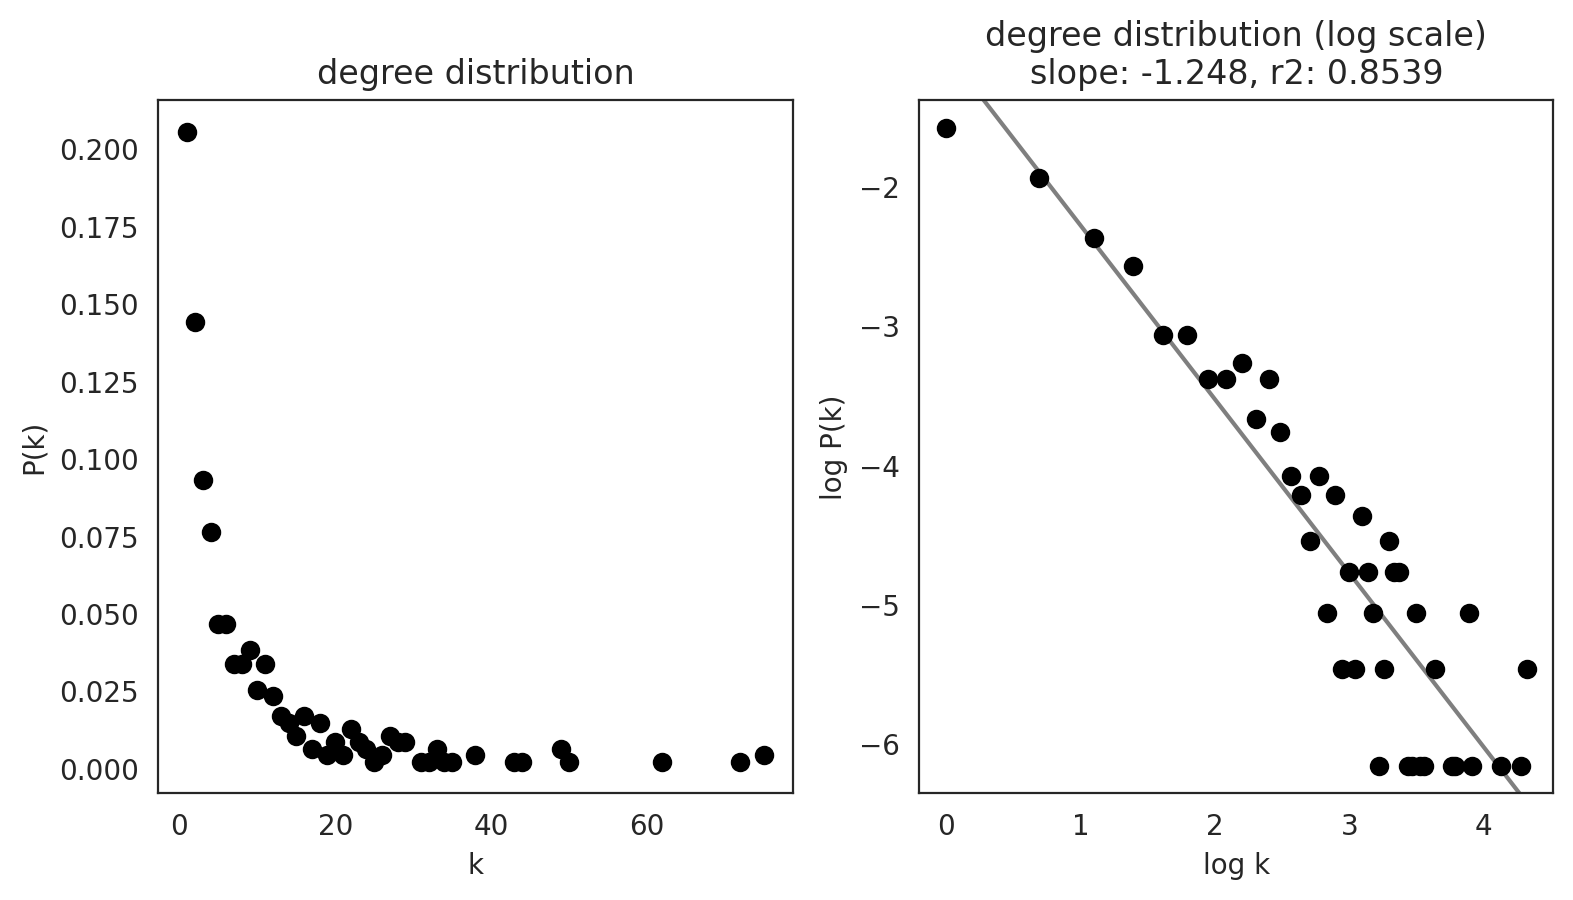

In [52]:
links.plot_degree_distributions(plot_model=True, 
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [53]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 6.3. Calculate netowrk score

Next, we calculate several network scores.


Although previous version of celloracle, `links.get_score()` required R packages for the netowrk score calculation, the function was replaced with new function, `links.get_network_scores()`, which does NOT require any R package. This new function can be available with celloracle >= 0.10.0.

The old function, `links.get_score()` is still available, but it will be removed in the future version.


In [47]:
# Calculate network scores. 
links.get_network_score()

The score is stored as a attribute `merged_score`.

In [48]:
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Utf1,119,0.238,19,0.038,100,0.200,5500.0,0.993214,2
Spp1,31,0.062,31,0.062,0,0.000,0.0,0.519106,2
Zfp42,152,0.304,0,0.000,152,0.304,0.0,0.979107,2
Ckb,21,0.042,21,0.042,0,0.000,0.0,0.423041,2
Nanog,107,0.214,16,0.032,91,0.182,3785.0,1.000000,2


## 6.4. Save

Save processed GRNs. We will use this file during the in in silico TF perturbation analysis.

In [49]:
# Save Links object.
links.to_hdf5(file_path=path+"/links"+d1+"_signatures_FullyConnectedGRN.celloracle.links")


In [ ]:
# You can load files with the following command.
links = co.load_hdf5(file_path=path+"/links"+d1+"_signatures_FullyConnectedGRN.celloracle.links")


**If you are not interested in network analysis you can skip the steps described below. 
Please go to the next step: in silico gene perturbation with GRNs**

https://morris-lab.github.io/CellOracle.documentation/tutorials/simulation.html

In [50]:
links.links_dict["2"]

,source,target,coef_mean,coef_abs,p,-logp
0,Klf8,1700017B05Rik,0.000510,0.000510,1.881070e-04,3.725595
1,Zfp809,1700017B05Rik,-0.000283,0.000283,3.533600e-04,3.451783
2,Hif1a,1700017B05Rik,0.000323,0.000323,1.101954e-02,1.957837
3,Otx2,1700017B05Rik,-0.000822,0.000822,2.943304e-03,2.531165
4,Esrrb,1700017B05Rik,0.001529,0.001529,2.468461e-09,8.607574
...,...,...,...,...,...,...
262659,Grhl2,Zyx,0.000493,0.000493,3.757218e-02,1.425134
262660,Sall4,Zyx,0.001591,0.001591,1.522041e-06,5.817574
262661,Mybl2,Zyx,0.000376,0.000376,2.322391e-01,0.634065
262662,E2f7,Zyx,0.000182,0.000182,1.308053e-01,0.883375


Please go to the next step: **in silico gene perturbation with GRNs**

https://morris-lab.github.io/CellOracle.documentation/tutorials/simulation.html